# Notebook showcasing essential Pandas techniques for handling and analyzing industrial sensor time series data.

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

sns.set_theme(style="darkgrid", font_scale=1.2)

**data transformation:**

In [109]:
df = pd.read_csv(
    "industrial_sensors.csv",
    sep=";",
    decimal=","
)
df.columns = df.columns.str.lower().str.replace(" ", "_")

In [110]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp'])
df.set_index('timestamp', inplace=True)

In [111]:
cols = ['temperature','vibration','pressure','flow_rate','efficiency']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

In [112]:
df[cols] = df[cols].fillna(df[cols].median())

In [113]:
df = df[~df.index.duplicated(keep='first')]

In [114]:
df_hourly = df.resample('1h').mean()
df_daily = df.resample('1D').agg({
    'temperature': ['mean','min','max'],
    'vibration': 'mean',
    'pressure': 'mean',
    'flow_rate': 'sum',
    'efficiency': 'mean'
})

In [115]:
Q1 = df_hourly[cols].quantile(0.25)
Q3 = df_hourly[cols].quantile(0.75)
IQR = Q3 - Q1

df_hourly[cols] = df_hourly[cols].clip(
    lower=Q1 - 1.5 * IQR,
    upper=Q3 + 1.5 * IQR,
    axis=1
)

**Standartization:**

In [116]:
scaler = StandardScaler()
df_hourly[cols] = scaler.fit_transform(df_hourly[cols])

In [117]:
df_hourly['rm_24h'] = df_hourly['temperature'].rolling(24).mean()
df_hourly['rs_24h'] = df_hourly['temperature'].rolling(24).std()

df_hourly['lag_1h'] = df_hourly['temperature'].shift(1)
df_hourly['lag_24h'] = df_hourly['temperature'].shift(24)

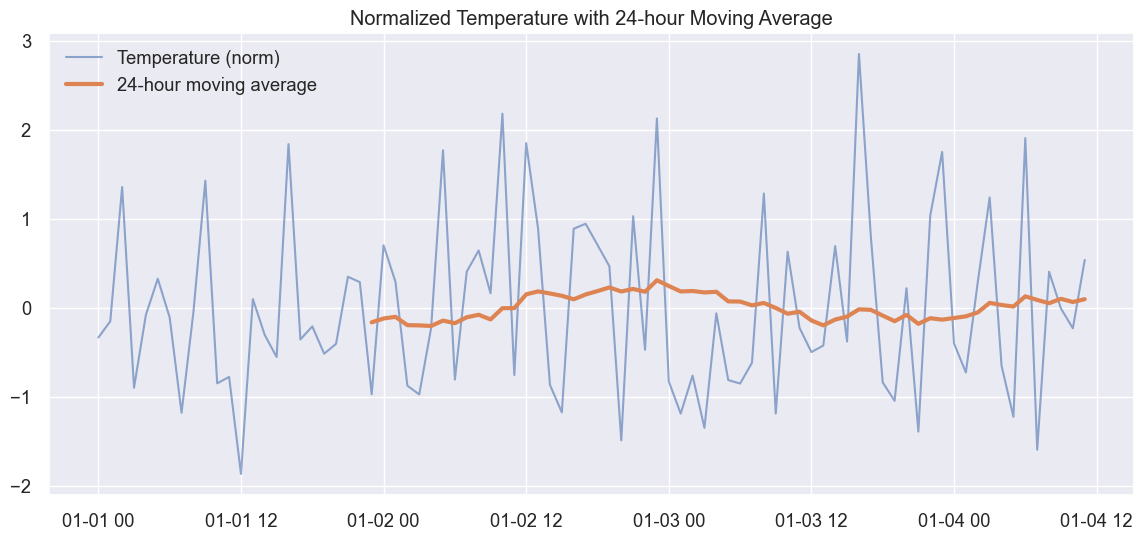

In [122]:
plt.figure(figsize=(14,6))
plt.plot(df_hourly.index, df_hourly['temperature'], alpha=0.6, label='Temperature (norm)')
plt.plot(df_hourly.index, df_hourly['rm_24h'], linewidth=3, label='24-hour moving average')
plt.legend()
plt.title("Normalized Temperature with 24-hour Moving Average")
plt.show()

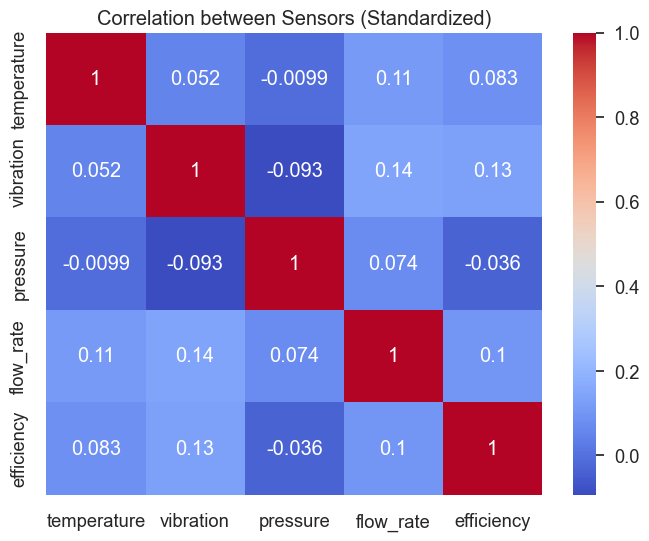

In [123]:
plt.figure(figsize=(8,6))
sns.heatmap(df_hourly[cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation between Sensors (Standardized)")
plt.show()

**Export data:**

In [124]:
df_hourly.to_csv("industrial_sensors_processed.csv", sep=";")

# Conclusion
In this project, we did the following:<br>
✔ Pandas for time series<br>
✔ Resample before normalizing<br>
✔ Real-time moving average<br>
✔ Normalization